In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bempp_pbs.postprocess import PLOT_PARAMS, get_df

In [2]:
plt.rcParams.update(PLOT_PARAMS)   # update plot style

load results

In [3]:
direct_df = get_df('../runs/5PTI_convergence/direct/', formulation='direct', skip4=True)
derivative_df = get_df('../runs/5PTI_convergence/derivative_ex/', formulation='derivative', skip4=True)
derivative_mass_matrix_df = get_df('../runs/5PTI_convergence/derivative_ex_mass_matrix/', formulation='derivative', skip4=True)

Compute relative error with respect to the extrapolated solution.

In [4]:
def richardson_extrapolation(f1, f2, f3):
    return (f1*f3 - f2**2) / (f3 - 2*f2 + f1) 

In [5]:
e_solv = direct_df['e_solv [kcal/Mol]'].values
e_solv_exact = richardson_extrapolation(*e_solv[-2:0:-1])
print('extrapolated solution using direct formulation: ', e_solv_exact)
rel_error_direct = np.abs((e_solv-e_solv_exact)/e_solv_exact)
e_solv = derivative_df['e_solv [kcal/Mol]'].values
e_solv_exact = richardson_extrapolation(*e_solv[-2:0:-1])
print('extrapolated solution using derivative formulation: ', e_solv_exact)
rel_error_derivative = np.abs((e_solv-e_solv_exact)/e_solv_exact)

extrapolated solution using direct formulation:  -313.59764676311323
extrapolated solution using derivative formulation:  -312.68602853438085


## Mesh refinement study using 5PTI

Next, we tested our code on a realistic structure - bovine pancreatic trypsin inhibitor.
Similarly, we compute its solvation energy using 5 meshes with the element density ranging from 1 to 16.
Same fine parameters were used as the previous test, to reveal the discretization error.
Since an analytical solution is not available for this geometry, the reference values for error estimation come from Richardson extrapolation.

#### Table: Mesh size and element density of 5 meshes used in the grid refinement study on 5PTI .

| number of elements | element density (# elem / sq Angstrom) |
|:------------------:|:---------------:|
|        3032        |        1        |
|        6196        |        2        |
|        12512       |        4        |
|        25204       |        8        |
|        50596       |        16       |

The figure below shows that the error of computing solvation energy of 5PTI converges linearly with respect to N, for both direct and derivative formulation.
Both convergence results confirm that bempp solves the mathematical model correctly.



#### Figure: Mesh convergence study of the solvation energy of bovine pancreatic trypsin inhibitor (PDB code 5PTI), using both direct formulation and derivative formulation. The error is with respect to the extrapolated solution using Richardson extrapolation.

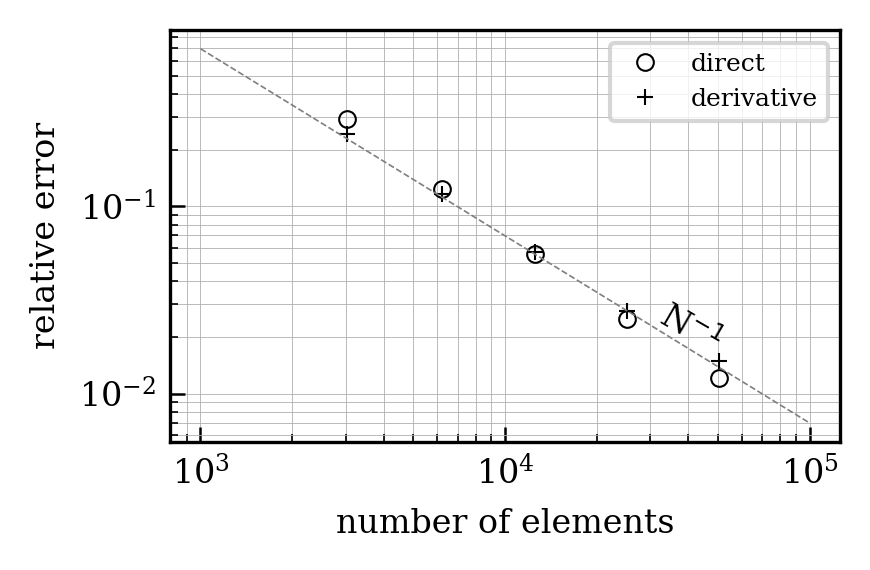

In [6]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
N = direct_df.index.values
N_ = np.array((1e3, 1e5))
asymp = N[2] * rel_error_direct[2] / N_
ax.loglog(N, rel_error_direct, linestyle='', marker='o', fillstyle='none', label='direct', color='black')
ax.loglog(N, rel_error_derivative, linestyle='', marker='+', fillstyle='none', label='derivative', color='black')
ax.loglog(N_, asymp, linestyle='--', color='#7f7f7f')
ax.grid(which="both")
ax.set_xlabel('number of elements')
ax.set_ylabel('relative error')
ax.legend()

loc = (3*N[-2]+N[-1])/4
text_loc = np.array((loc, 1.2*N[-2]*rel_error_direct[-2]/loc))
ax.text(text_loc[0], text_loc[1],r'N$^{-1}$', fontsize=8, rotation=-30,rotation_mode='anchor')
plt.tight_layout()
# plt.savefig('../../tex/figs/5PTI_convergence.pdf', dpi=300);

-----
### Appendix

1. Richardson extrapolation using 3 meshes
$$
\begin{equation}
\bar{f}=\frac{f_{1} f_{3}-f_{2}^{2}}{f_{1}-2 f_{2}+f_{3}}
\end{equation}
$$

2. relative error in percentage

#### direct

In [7]:
pd.DataFrame({'number of elements': direct_df.index, 'relative error (%)': rel_error_direct*100}).set_index('number of elements')

,relative error (%)
number of elements,
3032,29.241691
6196,12.404705
12512,5.566163
25204,2.497614
50596,1.211727


#### derivative

In [8]:
pd.DataFrame({'number of elements': direct_df.index, 'relative error (%)': rel_error_derivative*100}).set_index('number of elements')

,relative error (%)
number of elements,
3032,24.420170
6196,11.661036
12512,5.677938
25204,2.764675
50596,1.499250


3. raw result data

In [9]:
direct_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
3032,9.255245,41.141969,44,-405.298901,1.245852,1.994944,2.517442,1.489074,3.253786,2.509389,4.010676,34.101236,0.021797,0.185333,0.520669
6196,6.873639,55.456878,48,-352.498510,1.298352,1.984072,0.604215,1.515710,2.769642,4.833908,6.902839,42.929911,0.034514,0.214650,0.790220
12512,8.224664,87.453475,53,-331.053002,1.497760,2.529693,0.797550,1.513400,3.384022,8.860051,12.914149,64.242070,0.058701,0.292009,1.437205
25204,11.171512,171.576826,72,-321.430106,1.694780,2.761671,1.381049,1.528130,5.500661,24.296032,29.508209,114.710456,0.098361,0.382368,3.062129
50596,17.939818,301.352296,81,-317.397593,2.596536,3.672400,2.966928,1.650310,9.650179,35.566245,64.952653,194.572055,0.193311,0.579083,6.261343


In [10]:
derivative_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
3032,11.467519,53.837476,20,-389.044489,1.268228,3.063636,1.123780,2.73863,4.541472,3.047618,4.048155,46.063559,0.023001,0.190345,0.678145
6196,12.328889,65.472754,19,-349.148460,1.360512,2.073360,1.063001,2.88178,6.310748,4.657528,6.035649,53.222862,0.035926,0.230402,1.556715
12512,16.094679,92.094376,19,-330.440148,1.611068,3.515644,1.685500,2.79936,8.094174,8.467109,10.176532,71.267346,0.060575,0.308517,2.183389
25204,20.313739,121.308250,18,-321.330782,1.881372,3.067885,2.120460,2.79688,12.328514,13.368390,16.634562,87.766347,0.103966,0.398938,3.538950
50596,32.908272,195.402694,18,-317.373973,2.913360,3.941171,4.261869,3.05930,21.645932,22.829768,31.914846,133.534401,0.199468,0.606975,7.123678


In [11]:
derivative_mass_matrix_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
3032,8.878015,38.294068,14,-389.044497,1.266776,1.927307,0.594318,2.69806,3.658330,2.184614,2.939802,32.401477,0.022967,0.184099,0.768174
6196,10.256916,50.961094,15,-349.148450,1.381168,2.041324,0.730325,2.68155,4.803717,4.241707,4.847207,40.772995,0.035641,0.218037,1.099185
12512,14.382855,73.263648,16,-330.440136,1.610184,3.419241,1.042230,2.73290,7.188484,6.526180,8.560723,56.647088,0.059449,0.286096,1.529658
25204,19.547795,112.650256,17,-321.330778,1.934784,2.833449,1.917480,2.83897,11.957896,13.460070,15.276854,80.377198,0.100506,0.384580,3.536134
50596,32.397936,179.180266,17,-317.373969,3.027228,3.722781,4.091687,3.05140,21.532068,19.940254,30.031492,122.258945,0.197576,0.584971,6.949574
